In [14]:
import urllib.request
import os
import shutil
import gzip
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
import random
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, Binarizer
from sklearn.impute import SimpleImputer

## Zapoznanie się z zestawami danych


### MNIST

http://yann.lecun.com/exdb/mnist/


MNIST (Modified National Institute of Standards and Technology database) - duży zbiór ręcznie zapisanych cyfr. Zawiera znormalizowane obrazki (28x28 px, anti-alliasing). 
Posiada 60'000 obrazów treningowych i 10'000 testowych.


Musimy zacząć od pobrania i zdekowania danych. Można zrobic to np. na piechotę:

In [23]:
mnist_prefix = "./mnist"
if os.path.isdir(mnist_prefix):
    shutil.rmtree(mnist_prefix)
os.mkdir(mnist_prefix)
base_url = "http://yann.lecun.com/exdb/mnist/"
datasets = ["train-labels-idx1-ubyte.gz", "train-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz", "t10k-images-idx3-ubyte.gz"]

In [24]:
def fetch_gz(base_url, name):
    path = "{}/{}".format(mnist_prefix, name)
    urllib.request.urlretrieve("{}{}".format(base_url, name), path)
    data_file = gzip.open(path, "rb")
    data = data_file.read()
    data_file.close()
    return data

In [25]:
def decode_mnist(data):
    magic_number = int.from_bytes(data[0:4], byteorder='big')
    if magic_number == 2051:
        number_of_images = int.from_bytes(data[4:8], byteorder='big')
        rows = int.from_bytes(data[8:12], byteorder='big')
        columns = int.from_bytes(data[12:16], byteorder='big')
        print("File contains {} images {}x{}".format(number_of_images, rows, columns))
        pixels = [int(b) for b in data[16:]]
        return np.array(pixels).reshape((number_of_images, rows, columns))
    elif magic_number == 2049:
        number_of_labels = int.from_bytes(data[4:8], byteorder='big')
        print("File contain {} labels".format(number_of_labels))
        return [int(b) for b in data[8:]]

In [26]:
(train_labels, train_images, test_labels, test_images) = [decode_mnist(fetch_gz(base_url, ds)) for ds in datasets]

HTTPError: HTTP Error 403: Forbidden

In [16]:
plt.imshow(train_images[0])

NameError: name 'train_images' is not defined

In [ ]:
train_labels[0]

Lub w bardziej cywilizowany sposób używając gotowych funkcji bibliotek i pobierając dane np. z openml (https://www.openml.org/search?type=data):

In [ ]:
mnist = fetch_openml("mnist_784")

In [ ]:
plt.imshow(np.array(mnist.data[0]).reshape(28,28))

### Fashion-MNIST

Fashion-MNIST

Zbiór analogiczny do MNIST, zawiera obrazy przedstawiające elementy odzieży. 70'000 obrazów 28x28 px w skali szarości. Wskazywany jako następca MNIST ( MNIST jest uznawany za zbyt prosty, zbyt często używany, FMNIST lepiej oddaje współczesne problemy Computer Vision).


https://github.com/zalandoresearch/fashion-mnist

In [ ]:
fmnist = fetch_openml("Fashion-MNIST")

In [ ]:
print(fmnist.DESCR)

plt.imshow(np.array(fmnist.data[10]).reshape(28,28))
print('Category:', fmnist.target[10])

### CIFAR-10
https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
cifar10 = fetch_openml("CIFAR_10")

In [ ]:
print(cifar10.DESCR)

single_img_reshaped = np.transpose(np.array(cifar10.data[623]).reshape(3,32,32).astype(int) , (1,2,0))
plt.imshow(single_img_reshaped)

### SmallNorb

https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/

### TNG
https://github.com/RMHogervorst/TNG

TODO: Poprosić profesora o dostarczenie datasetu w formie wektorów.

## Procedury normalizujące dane i wybierające dane ze zbioru danych

TODO: opis procedur

### Wybieranie danych

Najprostszy sposób na zmniejszenie rozmiaru datasetu - wzięcie n początkowych elementów:


In [ ]:
fmnist_zipped = zip(fmnist.data, fmnist.target)
fmnist_reduced_list = list(fmnist_zipped)[:1000]

fmnist_reduced_data, fmnist_reduced_target = zip(*(fmnist_reduced_list))
print((list(fmnist_reduced_target)[0:10]))


Wzięcie _n_ losowych elementów z datasetu (bez modyfikacji kolejności w źródłowym datasecie):

In [ ]:
fmnist_random_sample = random.sample(fmnist_reduced_list, 100)
fmnist_reduced_data, fmnist_reduced_target = zip(*(fmnist_random_sample))
print((list(fmnist_reduced_target)[0:10]))

Podział danych na zbiór testowy oraz treningowy przy pomocy _sklearn_ :

In [ ]:
X = fmnist.data
y = fmnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train: ', len(X_train), ' y_train: ', len(y_train))
print('X_test: ', len(X_test), ' y_test: ', len(y_test))

### Normalizacja danych

TODO: Opisać bardziej poszczególne metody normalizacji i standaryzacji, dodać przykład ze zdjęciem

Normalizację danych wykonamy na danych UCI "Communities and Crime Unnormalized", dotyczących przestępczości w USA _(M=2215, N=143)_ .

https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
https://www.kaggle.com/kkanda/communities%20and%20crime%20unnormalized%20data%20set/data

In [ ]:
cc_prefix = "./communities_and_crimes"
cc_name = "crimedata.csv"
cc_path = "{}/{}".format(cc_prefix, cc_name)

In [ ]:
def csv_to_df(path):
    df = pd.read_csv(path)
    return df

In [ ]:
cc_df = csv_to_df(path).set_index(['communityname', 'state', 'countyCode', 'communityCode']).replace('?', np.NaN)
cc_df

#### Uzupełnianie brakujących danych

In [ ]:
imp=SimpleImputer(missing_values=np.NaN, strategy='mean')

cc_df_filled = pd.DataFrame(imp.fit_transform(cc_df.values), index=cc_df.index, columns=cc_df.columns)
cc_df_filled

#### Skalowanie Min-Max

In [ ]:
minmax = MinMaxScaler(feature_range=(0,1))
minmax_df = minmax.fit_transform(cc_df_filled)
df_scaled = pd.DataFrame(minmax_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
df_scaled

#### Standaryzacja

In [ ]:
standscaler = StandardScaler()
standscaler_df = standscaler.fit_transform(cc_df_filled)
st_df = pd.DataFrame(standscaler_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
st_df

#### Normalizacja

In [ ]:
norm = Normalizer(norm='l2')
norm_df = norm.fit_transform(cc_df_filled)
norm_df = pd.DataFrame(norm_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
norm_df

In [ ]:
norm = Normalizer(norm='l1')
norm_df = norm.fit_transform(cc_df_filled)
norm_df = pd.DataFrame(norm_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
norm_df

#### Binaryzacja

In [ ]:
binarizer = Binarizer(threshold=10.0).fit_transform(cc_df_filled)
binary_df = pd.DataFrame(binarizer, columns=cc_df_filled.columns, index=cc_df_filled.index)
binary_df

## Algorytm k-NN

Algorytm kNN (k najbliższych sąsiadów) oblicza dystans każdy-do-każdego w przestrzeni euklidesowej, po czym wybiera k najbliższych obiektów do rozważanego. Te k najbliższych sąsiadów uznaje się, że są najbardziej zbliżone cechami. Dla każdego punktu w przestrzeni bierzemy k najbliższych sąsiadów i przypisujemy go do klasy z etykietą, którą ma większość okolicznych punktów danych (tzw. majority voting).

#### Przykładowe wyszukanie najbliższego sąsiada

In [22]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

#n_neighbors - k z kNN
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
print(distances)
print(indices)

[[0.         1.        ]
 [0.         1.        ]
 [0.         1.41421356]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.41421356]]
[[0 1]
 [1 0]
 [2 1]
 [3 4]
 [4 3]
 [5 4]]


#### Przykładowe wykorzystanie

Poeksperymentuj z n_neighbors i zobacz, jak zmienia się przydział danego obszaru do klas.

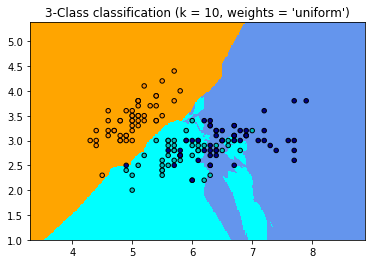

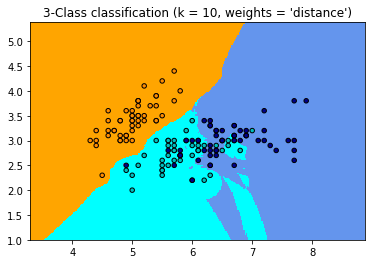

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 10

# importujemy przykładowy zbiór danych
iris = datasets.load_iris()

# bierzemy tylko 2 pierwsze wymiary z danych (żeby łatwo wizualizować)
X = iris.data[:, :2]
y = iris.target

h = .02  # jak duży rozmiar obszarów rozważanych

# mapy kolorków do wyświetlania
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # Używamy klasyfikatora i fitujemy dane
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Rezultat dodajemy do mapy
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Rysujemy też punkty danych
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

## Miary jakości klasyfikatora

- cross validation (scikit learn)
- leave-one-out

przykładowy dataset:
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [18]:
print("TODO: czy tutaj dać jakieś polecenia?")

TODO: czy tutaj dać jakieś polecenia?


## Zmiana miary jakości w zależności od zmniejszenia zbioru uczącego 
(stosunek dane uczące -> testowe)

In [19]:
print("TODO: przykładowe wywołania poleceń z opisem argumentów + zadanie czy można poprawić jakość")

TODO: przykładowe wywołania poleceń z opisem argumentów + zadanie czy można poprawić jakość


## Regularyzacja zbioru z małą ilością danych przez augmentację

TODO: pokazać jak zmieniają się miary jakości przy różnym stopniu nasilenia augmentacji (np interpolowanie zbioru punktami między już istniejącymi)

In [20]:
print("TODO: przykładowe wywołania poleceń")

TODO: przykładowe wywołania poleceń


## Procedury augmentacyjne z imgaug

TODO: 3-4 przykłady z imgaug

https://github.com/aleju/imgaug

Najlepiej w postaci samouczka z gotowymi poleceniami, więc tak z 5-6 komórek z paroma przykładami by pokazać jak się toto zachowuje przy różnych argumentach na różnych zbiorach danych (np 3 różne argumenty na 2 zbiory)

In [21]:
print("TODO: przykładowe wywołania poleceń, tym razem najlepiej w osobnych komórkach")

TODO: przykładowe wywołania poleceń, tym razem najlepiej w osobnych komórkach


## TODO: przygotować zadanie z imgaug na podstawie powyższych
by dało się w miarę bez googlowania je zrobić w miarę krótkim czasie - jest na to 50 min